## Problem 1: Sign Language Classification with CNN¶

As we studied in the lecture, CNN can classify images directly. So, the only thing we need to apply CNN is the picture of an object. This advantage allows CNN to applied to various industries. In this problem, we are going to classify sign language by CNN. Then you will able to directly conversate with disabled people even if you don't know sign language.

In [1]:
import os
import cv2
import numpy as np

import tensorflow as tf

from six.moves import cPickle
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

(1) Load and plot 6 random data.

You need to load total 4 files.

* sign_language_test_img.pkl
* sign_language_test_label.pkl
* sign_language_train_img.pkl
* sign_language_train_label.pkl

In [2]:
train_image = cPickle.load(open('./Sign_data/sign_language_train_img.pkl', 'rb'))
train_label = cPickle.load(open('./Sign_data/sign_language_train_label.pkl', 'rb'))

test_image = cPickle.load(open('./Sign_data/sign_language_test_img.pkl', 'rb'))
test_label = cPickle.load(open('./Sign_data/sign_language_test_label.pkl', 'rb'))

In [3]:
len(train_image), len(test_image)

(900, 337)

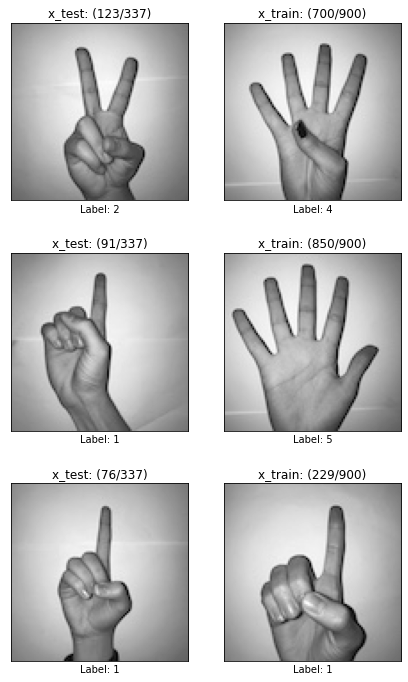

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(7, 12))
fig.set_facecolor('white')

for i, j in product(range(3), range(2)):
    if j == 0:
        rand_range = len(test_image)
        x_image = test_image; x_label = test_label; x_title = 'x_test'
        
    else:
        rand_range = len(train_image)
        x_image = train_image; x_label = train_label; x_title = 'x_train'
    
    rand_range = len(test_image) if j == 0 else len(train_image)
    rand_num = np.random.randint(rand_range)
    axes[i, j].imshow(x_image[rand_num], 'gray')
    axes[i, j].set_xlabel('Label: {}'.format(np.argmax(x_label[rand_num])))
    axes[i, j].set_title('{}: ({}/{})'.format(x_title, rand_num, rand_range))
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])

plt.show()

(2) Design your training and test dataset.

Note: you should check data shape. (CNN input is image!)

In [5]:
print('train_x:  {}'.format(np.array(train_image)[..., np.newaxis].shape))
print('train_y:  {}'.format(np.array(train_label).shape))
print('test_x:   {}'.format(np.array(test_image)[..., np.newaxis].shape))
print('test_y:   {}'.format(np.array(test_label).shape))

train_x:  (900, 100, 100, 1)
train_y:  (900, 6)
test_x:   (337, 100, 100, 1)
test_y:   (337, 6)


(3) Design your CNN structure.

* input
* filter size
* pooling size
* hidden layer
* output

Note: you should check data shape. (CNN input is image!)

In [6]:
# input layer
input_h = 100 # Input height
input_w = 100 # Input width
input_ch = 1 # Input channel : Gray scale
# (None, 100, 100, 1)

# First convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32 
p1_h = 2
p1_w = 2
# (None, 50, 50, 32)

# Second convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 25, 25, 64)

## Fully connected: flatten the features -> (None, 25*25*64)
conv_result_size = int(input_h/(p1_h*p2_h)) * int(input_w/(p1_w*p2_w)) * k2_ch
n_hidden = 100
n_output = 6

In [7]:
# kernel size: [kernel_height, kernel_width, input_ch, output_ch]
weights = {'conv1': tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch], stddev=0.1)), # (3*3*1) * 32
           'conv2': tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch], stddev=0.1)), # (3*3*32) * 64
           'hidden': tf.Variable(tf.random_normal([conv_result_size, n_hidden], stddev=0.1)),
           'output': tf.Variable(tf.random_normal([n_hidden, n_output], stddev=0.1))}

# bias size: [output_ch] or [neuron_size]
biases = {'conv1': tf.Variable(tf.random_normal([k1_ch], stddev=0.1)),
          'conv2': tf.Variable(tf.random_normal([k2_ch], stddev=0.1)),
          'hidden': tf.Variable(tf.random_normal([n_hidden], stddev=0.1)),
          'output': tf.Variable(tf.random_normal([n_output], stddev=0.1))}

# input layer: [batch_size, image_height, image_width, channels]
# output layer: [batch_size, class_size]
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

In [8]:
# we provide 'next_batch function' for your convenience (for tensorflow 1)
def next_batch(x, y, n_batch):
    x = np.array(x)
    y = np.array(y)
    
    m = x.shape[0]
    idx = np.random.randint(0, m, n_batch)
    x_train, y_train = x[idx].reshape(-1, 1), y[idx].reshape(-1, 1)
    
    return x_train, y_train

In [9]:
# [batch, height, width, channels]
def net(x, weights, biases):
    # First convolution layer
    conv1 = tf.nn.conv2d(x, 
                         weights['conv1'], 
                         strides=[1, 1, 1, 1], 
                         padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool2d(conv1, 
                           ksize=[1, p1_h, p1_w, 1], 
                           strides=[1, p1_h, p1_w, 1], # 겹치게 shift하면 안되서 ksize와 stride 일치!!!
                           padding='VALID')
    
    # Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, 
                         weights['conv2'], 
                         strides=[1, 1, 1, 1], 
                         padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool2d(conv2, 
                           ksize=[1, p2_h, p2_w, 1], 
                           strides=[1, p2_h, p2_w, 1], 
                           padding='VALID')

    maxp2_flatten = tf.reshape(maxp2, [-1, conv_result_size])
    
    # Fully connected
    hidden = tf.add(tf.matmul(maxp2_flatten, weights['hidden']), biases['hidden'])
    hidden = tf.nn.relu(hidden)
    output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])
    
    return output

In [10]:
LR = 0.0001

pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

optm = tf.compat.v1.train.AdamOptimizer(LR).minimize(loss)

In [11]:
n_batch = 50
n_iter = 2500
n_prt = 250

loss_record_train = []
loss_record_test = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_iter):  
        train_x, train_y = next_batch(train_image, train_label, n_batch)
        train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
        train_y = np.reshape(train_y, [-1, n_output])
        sess.run(optm, feed_dict={x: train_x,  y: train_y})

        if epoch % n_prt == 0:
            test_x, test_y = next_batch(test_image, test_label, n_batch)
            test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
            test_y = np.reshape(test_y, [-1, n_output])
            c1 = sess.run(loss, feed_dict={x: train_x, y: train_y})
            c2 = sess.run(loss, feed_dict={x: test_x, y: test_y})
            loss_record_train.append(c1)
            loss_record_test.append(c2)
            print ('Iter : {}'.format(epoch))
            print ('Cost : {}'.format(c1))
            
    test_x, test_y = next_batch(test_image, test_label, n_batch)
    test_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
    test_y = np.reshape(train_y, [-1, n_output])

    my_pred = sess.run(pred, feed_dict={x: test_x})
    my_pred = np.argmax(my_pred, axis=1)

    labels = np.argmax(test_y, axis=1)

2021-11-10 23:32:17.049688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-10 23:32:17.066344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-11-10 23:32:17.067200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-11-10 23:32:17.067952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-11-10 23:32:17.068591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-11

2021-11-10 23:32:17.560821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-11-10 23:32:17.561591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-11-10 23:32:17.562349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-11-10 23:32:17.562985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-11-10 23:32:17.563049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter : 0
Cost : 312.7626037597656
Iter : 250
Cost : 7.2963361740112305
Iter : 500
Cost : 0.004767090547829866
Iter : 750
Cost : 0.012833953835070133
Iter : 1000
Cost : 0.0
Iter : 1250
Cost : 0.0
Iter : 1500
Cost : 0.07144194096326828
Iter : 1750
Cost : 0.0
Iter : 2000
Cost : 0.0
Iter : 2250
Cost : 0.0


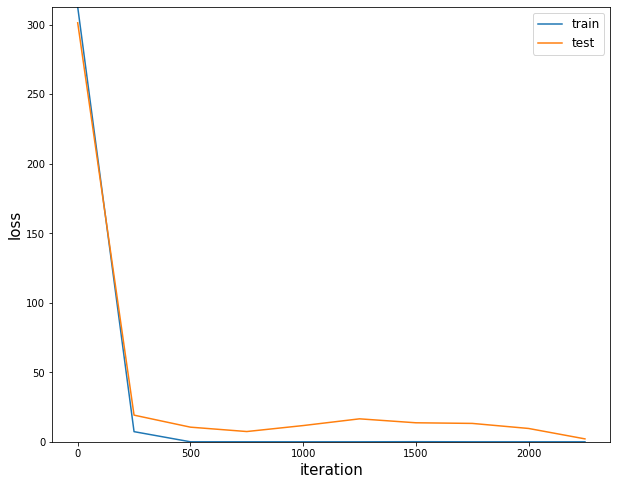

In [12]:
plt.figure(figsize = (10, 8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label='train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, label='test')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

(4) Test your model. Calculate accuracy and plot random image with its predicted and true label.

Note: test accuracy should higher than 80%.

In [13]:
accuracy = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(round(accuracy * 100, 2)))

Accuracy : 100.0%


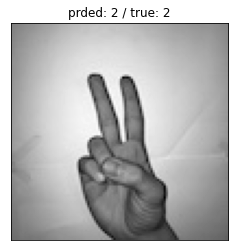

In [14]:
rand_num = np.random.randint(n_batch)
fig = plt.figure(figsize=(4, 4))
fig.set_facecolor('white')
plt.imshow(test_x[rand_num], 'gray')
plt.title('prded: {} / true: {}'.format(np.argmax(test_y[rand_num]), 
                                        labels[rand_num]))
plt.xticks([])
plt.yticks([])
plt.show()

### Problem 2: Understanding the Feature Map for Each Layer

In problem 2, let's build a CNN model that classifies steel surface defects.

* In order for CNN to preceed with classification, training was carried out using a convolution filter.
* Let's visualize the feature map for each convolutional layer to understand the CNN's decision boundary.
* NEU steel surface defects example.
* To classify defects images into 6 classes.

(1) Load and plot 3 random data for 6 classes.

You need to load total 4 files.

* NEU_train_imgs.npy
* NEU_train_labels.npy
* NEU_test_imgs.npy
* NEU_test_labels.npy

In [15]:
train_images = np.load('./NEU_data/NEU_train_imgs.npy')
train_label = np.load('./NEU_data/NEU_train_labels.npy')
test_images = np.load('./NEU_data/NEU_test_imgs.npy')
test_label = np.load('./NEU_data/NEU_test_labels.npy')

In [16]:
def print_data(set_name, set_len, set_shape):
    print('The number of {}: {}, shape: {}'.format(set_name, set_len, set_shape))
    
print_data('training images', len(train_images), train_images.shape)
print_data('training lables', len(train_label), train_label.shape)
print_data('testing images', len(test_images), test_images.shape)
print_data('testing labels', len(test_label), test_label.shape)

The number of training images: 1500, shape: (1500, 200, 200, 1)
The number of training lables: 1500, shape: (1500,)
The number of testing images: 300, shape: (300, 200, 200, 1)
The number of testing labels: 300, shape: (300,)


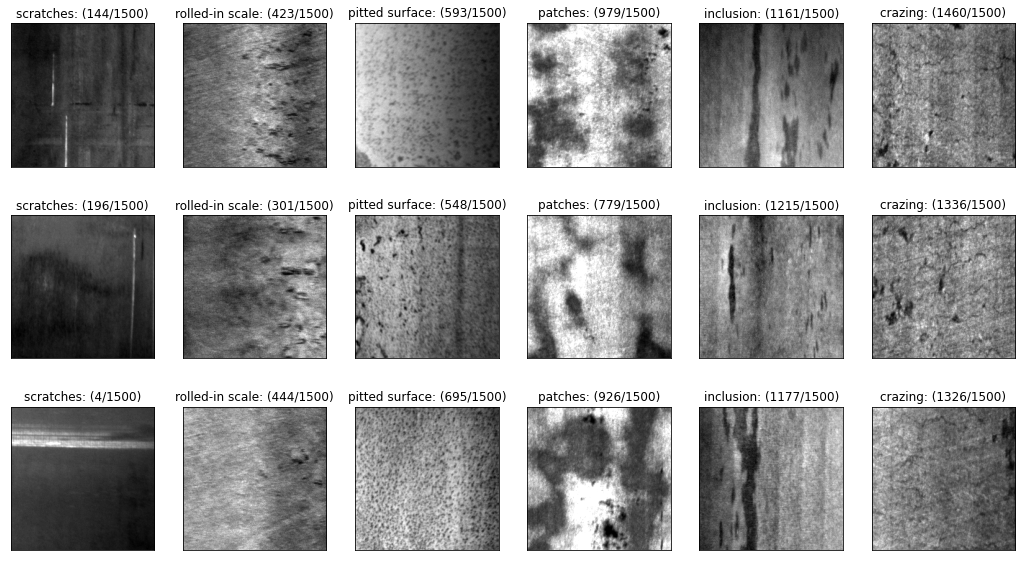

In [17]:
list_labels = ['scratches', 'rolled-in scale', 'pitted surface',
               'patches', 'inclusion', 'crazing']

fig, axes = plt.subplots(3, 6, figsize=(18, 10))
fig.set_facecolor('white')

for i, j in product(range(3), range(6)):
    label = list_labels[j]
    rand_num = np.random.randint(j * 250, (j+1) * 250)
    axes[i, j].imshow(train_images[rand_num].reshape(-1, 200), 'gray')
    axes[i, j].set_title('{}: ({}/{})'.format(label, rand_num, len(train_images)))
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])

plt.show()

(2) Design your CNN structure.

* input
* filter size
* pooling size
* hidden layer
* output

Note:

* Check data shape. (CNN input is image!)
* Check y-label shape. (you should implement one-hot encoding)
* Construct 5-convolution block (conv_layer - pool_layer) 

In [18]:
# input layer
input_h = 200 # Input height
input_w = 200 # Input width
input_ch = 1 # Input channel : Gray scale
# (None, 200, 200, 1)

# First convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32 
p1_h = 2
p1_w = 2
# (None, 100, 100, 32)

# Second convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 50, 50, 64)

# Third convolution layer
k3_h = 3
k3_w = 3
k3_ch = 128
p3_h = 2
p3_w = 2
# (None, 25, 25, 128)

# Fourth convolution layer
k4_h = 3
k4_w = 3
k4_ch = 256
p4_h = 2
p4_w = 2
# (None, 12, 12, 256)

# Fifth convolution layer
k5_h = 3
k5_w = 3
k5_ch = 512
p5_h = 2
p5_w = 2
# (None, 6, 6, 512)

## Fully connected: flatten the features -> (None, 6*6*512)
conv_result_size = int(input_h/(p1_h*p2_h*p3_h*p4_h*p5_h)
                      ) * int(input_w/(p1_w*p2_w*p3_w*p4_w*p5_w)) * k5_ch
n_hidden = 128
n_output = 6

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

In [19]:
def net(x, feature=False):
    # First convolution layer
    conv1 = tf.layers.conv2d(inputs=x, filters=k1_ch, kernel_size=[k1_h, k1_w], 
                             padding='SAME', activation=tf.nn.relu)
    maxp1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[p1_h, p1_w], strides=2)
    
    # Second convolution layer
    conv2 = tf.layers.conv2d(inputs=maxp1, filters=k2_ch, kernel_size=[k2_h, k2_w], 
                             padding='SAME', activation=tf.nn.relu,
                             kernel_initializer=tf.initializers.random_normal())
    maxp2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[p2_h, p2_w], strides=2)
    
    # Third convolution layer
    conv3 = tf.layers.conv2d(inputs=maxp2, filters=k3_ch, kernel_size=[k3_h, k3_w], 
                             padding='SAME', activation=tf.nn.relu,
                             kernel_initializer=tf.initializers.random_normal())
    maxp3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[p3_h, p3_w], strides=2)
    
    # Fourth convolution layer
    conv4 = tf.layers.conv2d(inputs=maxp3, filters=k4_ch, kernel_size=[k4_h, k4_w], 
                             padding='SAME', activation=tf.nn.relu,
                             kernel_initializer=tf.initializers.random_normal())
    maxp4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[p4_h, p4_w], strides=2)
    
    # Fifth convolution layer
    conv5 = tf.layers.conv2d(inputs=maxp4, filters=k5_ch, kernel_size=[k5_h, k5_w], 
                             padding='SAME', activation=tf.nn.relu,
                             kernel_initializer=tf.initializers.random_normal())
    maxp5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[p5_h, p5_w], strides=2)

    maxp5_flatten = tf.reshape(maxp5, [-1, conv_result_size])
    
    ## Fully connected (= dense connected)
    hidden = tf.layers.dense(inputs=maxp5_flatten, units=n_hidden, activation=tf.nn.relu)
    output = tf.layers.dense(inputs=hidden, units=n_output)
    
    if feature:
        return output, conv1, conv2, conv3, conv4, conv5
    return output

In [20]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
train_label = enc.fit_transform(train_label.reshape(-1, 1)).toarray()
test_label = enc.fit_transform(test_label.reshape(-1, 1)).toarray()

In [21]:
LR = 0.001

pred = net(x)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

optm = tf.compat.v1.train.AdamOptimizer(LR).minimize(loss)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [22]:
n_batch = 30
n_iter = 1000
n_prt = 50

loss_record_train = []
loss_record_test = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_iter):  
        train_x, train_y = next_batch(train_images, train_label, n_batch)
        train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
        train_y = np.reshape(train_y, [-1, n_output])
        sess.run(optm, feed_dict={x: train_x,  y: train_y})

        if epoch % n_prt == 0:
            test_x, test_y = next_batch(test_images, test_label, n_batch)
            test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
            test_y = np.reshape(test_y, [-1, n_output])
            c1 = sess.run(loss, feed_dict={x: train_x, y: train_y})
            c2 = sess.run(loss, feed_dict={x: test_x, y: test_y})
            loss_record_train.append(c1)
            loss_record_test.append(c2)
            print ('Iter : {}'.format(epoch))
            print ('Cost : {}'.format(c1))
            
    test_x, test_y = next_batch(test_images, test_label, n_batch)
    test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
    test_y = np.reshape(test_y, [-1, n_output])

    my_pred = sess.run(pred, feed_dict={x: test_x})
    my_pred = np.argmax(my_pred, axis=1)

    labels = np.argmax(test_y, axis=1)
    
    test_x, test_y = next_batch(test_images, test_label, 1)
    test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
    test_y = np.reshape(test_y, [-1, n_output])

    test_pred = sess.run(tf.nn.softmax(pred), feed_dict={x: test_x})
    test_label = np.argmax(test_y, axis=1)

2021-11-10 23:34:34.057524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-11-10 23:34:34.058467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-11-10 23:34:34.059375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-11-10 23:34:34.060164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-11-10 23:34:34.060227: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter : 0
Cost : 337398.21875
Iter : 50
Cost : 628.1553344726562
Iter : 100
Cost : 109.4578628540039
Iter : 150
Cost : 43.54008102416992
Iter : 200
Cost : 100.70764923095703
Iter : 250
Cost : 123.44759368896484
Iter : 300
Cost : 0.0
Iter : 350
Cost : 14.552278518676758
Iter : 400
Cost : 0.0
Iter : 450
Cost : 9.122754096984863
Iter : 500
Cost : 9.300456047058105
Iter : 550
Cost : 134.88720703125
Iter : 600
Cost : 25.757030487060547
Iter : 650
Cost : 0.0
Iter : 700
Cost : 0.0
Iter : 750
Cost : 0.0
Iter : 800
Cost : 0.0
Iter : 850
Cost : 0.0
Iter : 900
Cost : 84.20191955566406
Iter : 950
Cost : 0.0


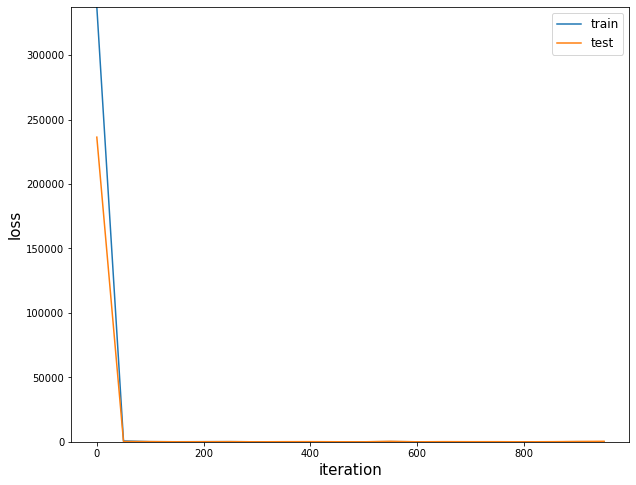

In [23]:
plt.figure(figsize = (10, 8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label='train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, label='test')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

(3) Test your model. Calculate accuracy and plot random image with its predicted and true label.

Note: test accuracy should higher than 90%.

In [24]:
accuracy = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(round(accuracy * 100, 2)))

Accuracy : 96.67%


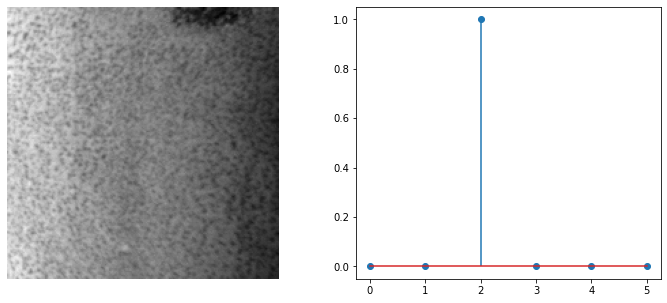

Prediction: pitted surface
True Label: pitted surface


In [25]:
rand_num = np.random.randint(n_batch)
fig = plt.figure(figsize=(12, 5))
fig.set_facecolor('white')

plt.subplot(1, 2, 1)
plt.imshow(test_x.reshape(input_h, input_w), 'gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.stem(test_pred.ravel())
plt.show()

print('Prediction: {}'.format(list_labels[test_label[0]]))
print('True Label: {}'.format(list_labels[np.argmax(test_pred.ravel())]))

(4) Visualize the feature maps (output) for the convolutional layers from 1 to 5.

- Visualize the output using the first data from the test dataset.
- Visualize up to 6 channels on each layer.

In [26]:
train_images = np.load('./NEU_data/NEU_train_imgs.npy')
train_label = np.load('./NEU_data/NEU_train_labels.npy')
test_images = np.load('./NEU_data/NEU_test_imgs.npy')
test_label = np.load('./NEU_data/NEU_test_labels.npy')

train_label = enc.fit_transform(train_label.reshape(-1, 1)).toarray()
test_label = enc.fit_transform(test_label.reshape(-1, 1)).toarray()

In [27]:
LR = 0.001

pred, conv1, conv2, conv3, conv4, conv5 = net(x, feature=True)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

optm = tf.compat.v1.train.AdamOptimizer(LR).minimize(loss)

In [28]:
n_batch = 30
n_iter = 1000
n_prt = 50

loss_record_train = []
loss_record_test = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_iter):  
        train_x, train_y = next_batch(train_images, train_label, n_batch)
        train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
        train_y = np.reshape(train_y, [-1, n_output])
        sess.run(optm, feed_dict={x: train_x,  y: train_y})

        if epoch % n_prt == 0:
            test_x, test_y = next_batch(test_images, test_label, n_batch)
            test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
            test_y = np.reshape(test_y, [-1, n_output])
            c1 = sess.run(loss, feed_dict={x: train_x, y: train_y})
            c2 = sess.run(loss, feed_dict={x: test_x, y: test_y})
            loss_record_train.append(c1)
            loss_record_test.append(c2)
            print ('Iter : {}'.format(epoch))
            print ('Cost : {}'.format(c1))
            
    rand_num = np.random.randint(n_batch)
    feature_x = test_x[rand_num].reshape(-1, input_h, input_w, input_ch)
    my_conv1 = sess.run(conv1, feed_dict={x: feature_x})
    my_conv2 = sess.run(conv2, feed_dict={x: feature_x})
    my_conv3 = sess.run(conv3, feed_dict={x: feature_x})
    my_conv4 = sess.run(conv4, feed_dict={x: feature_x})
    my_conv5 = sess.run(conv5, feed_dict={x: feature_x})

2021-11-10 23:40:18.998744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-11-10 23:40:18.999676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-11-10 23:40:19.000596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-11-10 23:40:19.001397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-11-10 23:40:19.001531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter : 0
Cost : 225582.3125
Iter : 50
Cost : 283.6071472167969
Iter : 100
Cost : 42.94896697998047
Iter : 150
Cost : 26.35268783569336
Iter : 200
Cost : 59.306461334228516
Iter : 250
Cost : 107.12506866455078
Iter : 300
Cost : 143.6894989013672
Iter : 350
Cost : 0.0
Iter : 400
Cost : 44.82436752319336
Iter : 450
Cost : 0.0
Iter : 500
Cost : 44.042869567871094
Iter : 550
Cost : 9.51406478881836
Iter : 600
Cost : 0.0
Iter : 650
Cost : 7.879435062408447
Iter : 700
Cost : 0.0
Iter : 750
Cost : 0.0
Iter : 800
Cost : 0.0
Iter : 850
Cost : 0.0
Iter : 900
Cost : 0.0
Iter : 950
Cost : 0.0


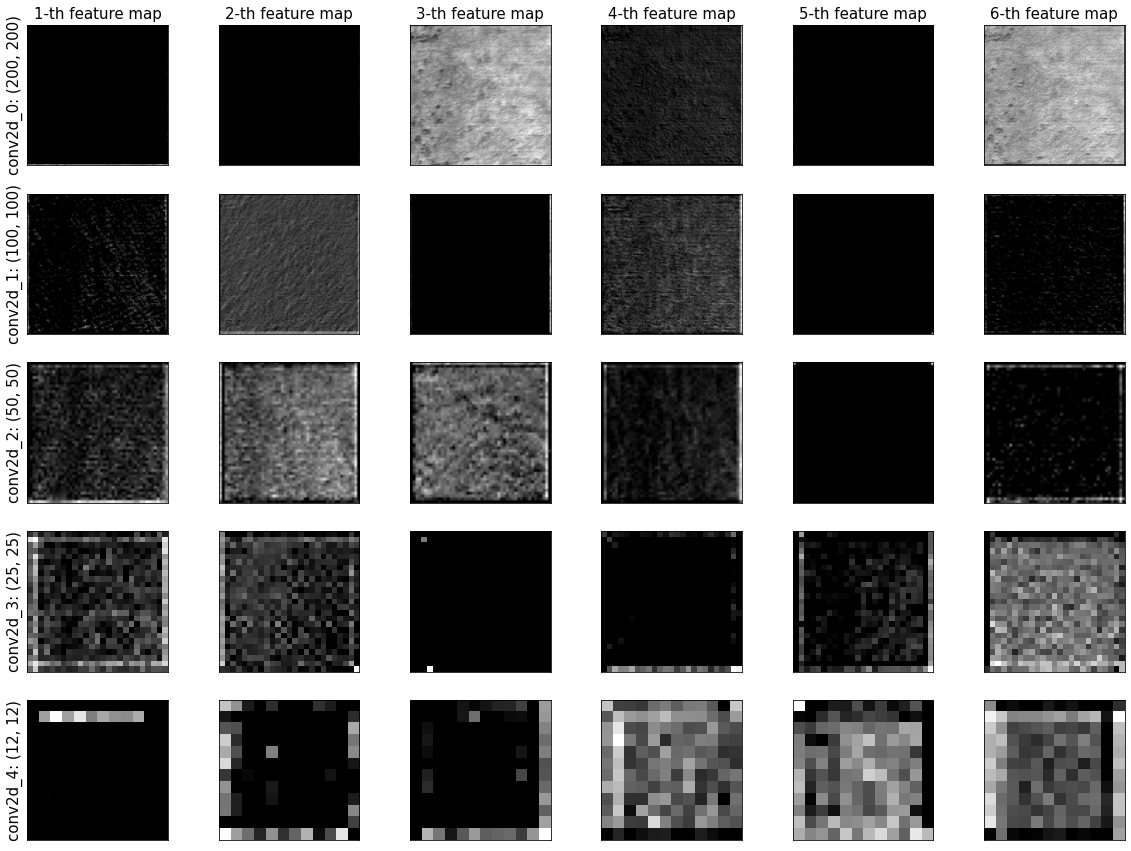

In [29]:
fig, axes = plt.subplots(5, 6, figsize=(20,15))
fig.set_facecolor('white')

dict_map = {1: (my_conv1, input_h), 2: (my_conv2, int(input_h/2)), 
            3: (my_conv3, int(input_h/2/2)), 4: (my_conv4, int(input_h/2/2/2)), 
            5: (my_conv5, int(input_h/2/2/2/2))}

for i, j in product(range(5), range(6)):
    axes[i, j].imshow(dict_map[i+1][0][0][:, :, j], 'gray')
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[0, j].set_title('{}-th feature map'.format(j+1), fontsize=15)
    axes[i, 0].set_ylabel('conv2d_{}: ({}, {})'.format(
        i, dict_map[i+1][1], dict_map[i+1][1]), fontsize=15)
    
plt.show()